## Split Folders

In [ ]:
!pip install splitfolders

In [ ]:
import splitfolders

In [ ]:
input_dir='Karnataka_Snacks'
output_dir='dataset'
splitfolders.ratio(input_dir,output_dir,seed=42,ratio=(.85,0,.15))

In [ ]:
help(splitfolders.ratio)

## Import Libraries and Define the data split

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout,Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras

## Check for bad images

import pathlib
from sklearn.model_selection import train_test_split

datadir=pathlib.Path('Karnataka_Snacks')
data={'Ambode':list(datadir.glob('Ambode/*')),
    'Chakli':list(datadir.glob('Chakli/*')),
    'Chigali_Unde':list(datadir.glob('Chigali_Unde/*')),
    'Golibaje':list(datadir.glob('Golibaje/*')),
    'Kajjaya':list(datadir.glob('Kajjaya/*')),
    'Kobri_Mithai':list(datadir.glob('Kobri_Mithai/*')),
    'Kodubale':list(datadir.glob('Kodubale/*')),
    'Maddur_Vade':list(datadir.glob('Maddur_Vade/*')),
    'Mysore_Pak':list(datadir.glob('Mysore_Pak/*')),
    'Nuchinunde':list(datadir.glob('Nuchinunde/*')),
    'Obbattu':list(datadir.glob('Obbattu/*')),
    'Puri_Unde':list(datadir.glob('Puri_Unde/*'))
    }
from PIL import Image
X,y=[],[]
for snacks,images in data.items():
    for image in images:
        try:
          img = Image.open(image) # open the image file
          img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
          print('Bad file:', image) # print out the names of corrupt files


In [5]:
img_height,img_width=(224,224)
batch_size=32

train_datadir='dataset/train'
test_datadir='dataset/test'

In [6]:
## Data augmentation
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                shear_range=0.1,
                                zoom_range=0.25,
                                brightness_range=(0.2,0.4),
                                horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=90,
                                fill_mode='nearest',
                                validation_split=0.2)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory(train_datadir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 subset='training')
val_generator=train_datagen.flow_from_directory(train_datadir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 subset='validation')
test_generator=test_datagen.flow_from_directory(test_datadir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 color_mode='rgb')

Found 1008 images belonging to 12 classes.
Found 252 images belonging to 12 classes.
Found 276 images belonging to 12 classes.


print(X.shape)
print(y.shape)

In [7]:
X,y=train_generator.next()
print(X.shape)

(32, 224, 224, 3)


## Resnet50 architecture Transfer Learning Model

In [8]:
img_width,img_height=224,224

from keras import backend as k
if k.image_data_format()=='chanels_first':
    input_shape=(3,img_width,img_height) 
else:
    input_shape=(img_width,img_height,3)
    
base_model=ResNet50(include_top=False,
                   input_shape=input_shape,
                   weights='imagenet')
    
model=base_model.output
model=GlobalAveragePooling2D()(model)
model=Dense(1024, activation='relu')(model)
model=Dropout(0.5)(model)
model=Dense(64,activation='relu')(model)
model=Dropout(0.2)(model)
model=Dense(train_generator.num_classes, activation='softmax')(model)

model=Model(inputs=base_model.input,outputs=model)

for layer in base_model.layers:
    layer.trainable=False
    
model.summary()
    


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [12]:
len(base_model.layers)


175

In [10]:
!pip install visualkeras

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/04/0b/52a3be50d3421977d779a159f6be484e7aa2c5304f6278ede5ed7c491ef5/aggdraw-1.3.18-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/44.9 kB ? eta -:--:--
   ---------------------------------------- 44.9/44.9 kB 753.2 kB/s eta 0:00:00


In [20]:
b=ResNet50(include_top=True,
                   input_shape=input_shape,
                   weights='imagenet')

102967424/102967424 [==============================] - 29s 0us/step


In [ ]:
m=b.output
m=GlobalAveragePooling2D()(m)
m=Dense(1024, activation='relu')(m)
m=Dropout(0.5)(m)
m=Dense(64,activation='relu')(m)
m=Dropout(0.2)(m)
m=Dense(train_generator.num_classes, activation='softmax')(m)

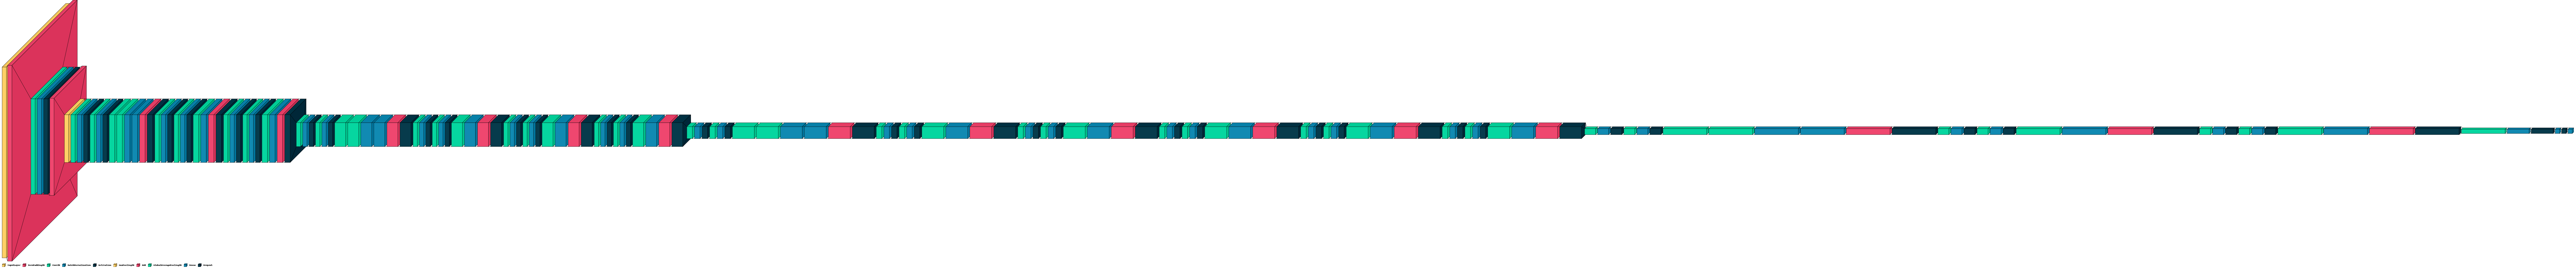

In [22]:
import visualkeras
visualkeras.layered_view(model,legend=True)

In [27]:
!pip install pydot

In [31]:
!pip install pydotplus

     ---------------------------------------- 0.0/278.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/278.7 kB 660.6 kB/s eta 0:00:01
     ----- ------------------------------- 41.0/278.7 kB 495.5 kB/s eta 0:00:01
     -------- ---------------------------- 61.4/278.7 kB 469.7 kB/s eta 0:00:01
     ------------ ------------------------ 92.2/278.7 kB 438.1 kB/s eta 0:00:01
     -------------- --------------------- 112.6/278.7 kB 437.6 kB/s eta 0:00:01
     --------------- -------------------- 122.9/278.7 kB 425.1 kB/s eta 0:00:01
     ------------------ ----------------- 143.4/278.7 kB 448.2 kB/s eta 0:00:01
     ---------------------- ------------- 174.1/278.7 kB 456.4 kB/s eta 0:00:01
     ------------------------- ---------- 194.6/278.7 kB 454.0 kB/s eta 0:00:01
     ------------------------- ---------- 194.6/278.7 kB 454.0 kB/s eta 0:00:01
     ------------------------- ---------- 194.6/278.7 kB 454.0 kB/s eta 0:00:01
     ----------------------------- ------ 225.3

In [29]:
!pip install graphviz

In [32]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9),
              metrics=['accuracy'])

model.fit(train_generator,
          validation_data=val_generator,
          epochs=20)

model.save('train.h5')

Epoch 1/20
39/39 [==============================] - 130s 3s/step - loss: 0.0992 - accuracy: 0.9624 - val_loss: 0.2159 - val_accuracy: 0.9340
Epoch 2/20
39/39 [==============================] - 122s 3s/step - loss: 0.0993 - accuracy: 0.9657 - val_loss: 0.1913 - val_accuracy: 0.9618
Epoch 3/20
39/39 [==============================] - 132s 3s/step - loss: 0.1145 - accuracy: 0.9583 - val_loss: 0.2008 - val_accuracy: 0.9271
Epoch 4/20
39/39 [==============================] - 128s 3s/step - loss: 0.0914 - accuracy: 0.9681 - val_loss: 0.2074 - val_accuracy: 0.9375
Epoch 5/20
39/39 [==============================] - 126s 3s/step - loss: 0.0888 - accuracy: 0.9706 - val_loss: 0.2325 - val_accuracy: 0.9201
Epoch 6/20
39/39 [==============================] - 124s 3s/step - loss: 0.0806 - accuracy: 0.9722 - val_loss: 0.2116 - val_accuracy: 0.9340
Epoch 7/20
39/39 [==============================] - 124s 3s/step - loss: 0.0714 - accuracy: 0.9788 - val_loss: 0.2505 - val_accuracy: 0.9271
Epoch 8/20
39

In [29]:
print(model.evaluate(train_generator,verbose=2))


39/39 - 93s - loss: 0.0129 - accuracy: 0.9984 - 93s/epoch - 2s/step
[0.012942283414304256, 0.9983659982681274]


In [30]:
print(model.evaluate(val_generator,verbose=2))

10/10 - 23s - loss: 0.2330 - accuracy: 0.9333 - 23s/epoch - 2s/step
[0.2329995036125183, 0.9333333373069763]


In [31]:
print(model.evaluate(test_generator,verbose=2))

276/276 - 33s - loss: 0.1847 - accuracy: 0.9457 - 33s/epoch - 118ms/step
[0.18466702103614807, 0.945652186870575]


## Confusion Matrix

test_accuracy: 94.56521739130434


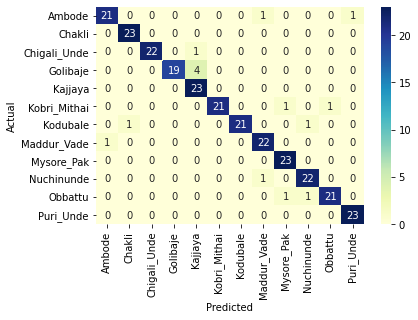

In [32]:
import pandas as pd
import seaborn as sn

model=tf.keras.models.load_model('train.h5')
filename=test_generator.filenames
nb_samples=len(test_generator)
y_probability=[]
y_actual=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_probability.append(model.predict(X_test))
    y_actual.append(Y_test)
    
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_probability]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_actual]

output_dataframe=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,
                              columns=['predicted_class','actual_class'])

confusion_matrix=pd.crosstab(output_dataframe['actual_class'],
                             output_dataframe['predicted_class'],
                            rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='YlGnBu', annot=True, fmt='d')
print('test_accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))
plt.show()

In [16]:
train_generator.class_indices.keys()

dict_keys(['Ambode', 'Chakli', 'Chigali_Unde', 'Golibaje', 'Kajjaya', 'Kobri_Mithai', 'Kodubale', 'Maddur_Vade', 'Mysore_Pak', 'Nuchinunde', 'Obbattu', 'Puri_Unde'])

## Snack Prediction

In [2]:
model=tf.keras.models.load_model('train.h5')

In [4]:
threshold=0.151
def scope(pred):
    for score in pred:
        if score>=threshold:
            return True
    return False

tf.Tensor(
[0.07595394 0.07845682 0.07885759 0.11237532 0.07641226 0.07764362
 0.07620712 0.10833057 0.07607701 0.07926996 0.07642254 0.08399328], shape=(12,), dtype=float32)
3
Not a Karnataka Snack :/


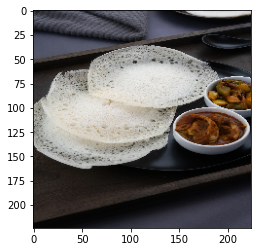

In [5]:
img=image.load_img('Resources/55.jpg',target_size=(224,224))

img_recog=image.img_to_array(img)
img_recog=np.expand_dims(img_recog,axis=0)

img_preprocess=preprocess_input(img_recog) ##keras function to normalise pixels in the input image
result=model.predict(img_preprocess)
score=tf.nn.softmax(result[0])
print(score)

print(np.argmax(score))
score=np.argmax(score)
maxscore=scope(tf.nn.softmax(result[0]))

plt.imshow(img)
if maxscore>=threshold:
    if score==0:
        recognition='Ambode'
    elif score==1:
        recognition='Chakli'
    elif score==2:
        recognition='Chigali_Unde'
    elif score==3:
        recognition='Golibaje'
    elif score==4:
        recognition='Kajjaya'
    elif score==5:
        recognition='Kobbri_Mithai'
    elif score==6:
        recognition='Kodubale'
    elif score==7:
        recognition='Maddur_Vade'
    elif score==8:
        recognition='Mysore_Pak'
    elif score==9:
        recognition='Nuchinunde'
    elif score==10:
        recognition='Obbattu'
    else:
        recognition='Puri_Unde'
else:
    recognition="Not a Karnataka Snack :/"
    
print(recognition)